In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyabeles as pa
%matplotlib inline
from pyabeles.materials import * #Imports default materials that I've included (really unsure about their values)

# Forward Solve

First try at an implementation of the Abeles matrix formulation for curve generation... using OOP!

We generate the curve using Abeles Matrix Formalism (I believe this is what Jason was talking about when discussing the matrix multiplication method, Parratt formalism is actually a recursive method). Read more here: https://en.wikipedia.org/wiki/Transfer-matrix_method_(optics)#Abeles_matrix_formalism

I've abstracted away the main Abeles code into a python module I made. So we can now move straight to building up a structure and plotting its curve, 

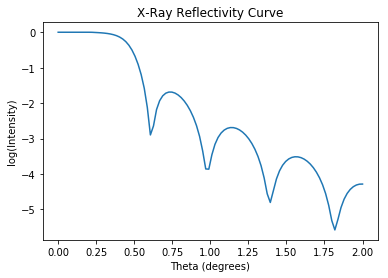

In [2]:
struct = pa.Surface()
nickel = pa.Layer(100.,72.12232398, sigma=5., name="nickel")
silicon = pa.Layer(0., 19.57422247, sigma=5., name="silicon substrate")

struct.addLayer(nickel) #Add first layer
struct.addLayer(silicon) # Add silicon substrate (unsure about these for rho, grabbed them from online)
angles = np.linspace(0.,2.,100) # Angles in degrees

exp = struct.doExperiment(angles)
exp.simulatePlot()

Alternatively,

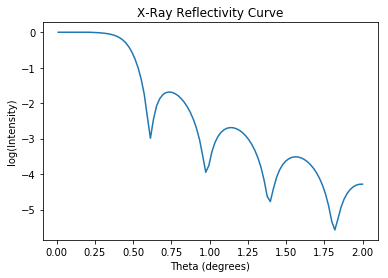

In [3]:
angles = np.linspace(0.01,2.,100)
(nickel+silicon).doExperiment(angles).simulatePlot()

Looks sorta like the curves I found online and like what Jason drew up on the whiteboard!

### Jason's Suggestion

Alternating layers of A and B on a substrate, 20 angstroms and 40 angstroms. You should be able to see peaks.

In [4]:
A = pa.Layer(40.,72.12232398, sigma=0., name="A")
B = pa.Layer(20.,72.12232398/2, sigma=0., name="B")
subst = pa.Layer(0., 19.57422247, sigma=5., name="silicon substrate")

Structure built from top to bottom, with substrate on bottom. Like so,

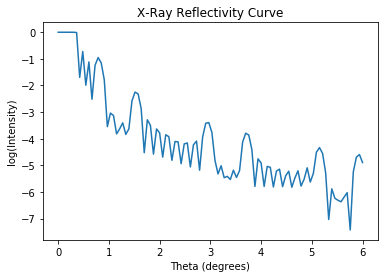

In [5]:
struct = A+B+A+B+A+B+A+B+subst
angles = np.linspace(0.,6.,100) # Angles in degrees
struct.doExperiment(angles).simulatePlot()

Peaks as expected!

# The Inverse Problem

Let's start by writing down a likelihood function. Let $\vec{\theta}$ be the vector of parameters ($\vec{\rho}$, $\vec{\sigma}$, $\vec{d}$, etc), $\vec{x}$ be the angles we tried and $\vec{R}$ be the measured reflectivity. 

We have
$P(\vec{R}|\vec{\theta}, \vec{x})$ as the likelihood function. Assumng that errors are uncorrelated, 
$$P(\vec{R}|\vec{\theta}, \vec{x}) = \Pi_i P(R_i|\vec{\theta},x_i)$$
Making the further assumpton of normal errors, we have ($\sigma$ here is variance, not roughness and $\hat{R}_i$ is predicted reflection given $\vec{\theta}$)
$$P(\vec{R}|\vec{\theta}, \vec{x}) = \Pi_i \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-(R_i- \hat{R}_i)^2/2 \sigma^2}$$
$$\therefore -\log(P(\vec{R}|\vec{\theta},\vec{x})) = \sum_i \frac{(R_i- \hat{R}_i)^2}{2 \sigma^2} + C$$

We want to minimize this and thus maximize the probability that we would see the data given $\vec{\theta}$ (MLE). Let's try to start with just some basic SciPy optimization packages....

## Nelder-Mead Simplex 

### Isolating Gaps - A really simple toy model

Let's start fitting by assuming knowledge of the surface structure, just not the exact size of the layers

In [6]:
struct = B+A+B+subst #Build a simple B-A-B structure
angles = np.linspace(0.,6.,100) # Generate an experiment with 100 samples of degrees 0 to 6
exp = struct.doExperiment(angles)
R = exp.genTheory()

Look at what happens when we perturb the thickness by just a little bit (~2 angstroms)

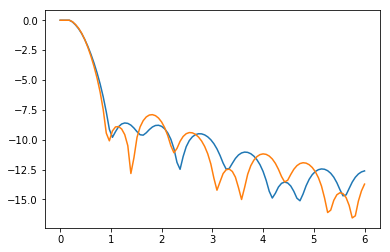

In [7]:
guess = struct.d.copy()
guess[1] = 14.9 #Perturb thickness a little bit

#Create a new structure with perturbed thickness
badstruct = struct.copy()
badstruct.d = guess
plt.plot(angles,np.log(badstruct.doExperiment(angles).genTheory()))
plt.plot(angles,np.log(struct.doExperiment(angles).genTheory()))

Now build an experiment off of the incorrect structure and try to fix it using the collected data back to the original structure. You'll see that the original and the fixed bad structure are indistinguishable. Over ~5.4 ang. off and the error is not surmountable by Nelder-Mead, not super-duper promising. 

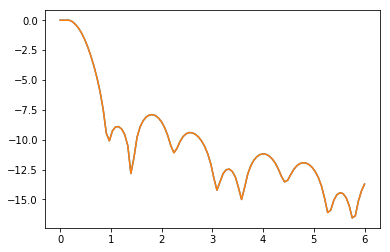

In [8]:
exp = pa.Experiment(angles,R,surf=badstruct) 
fixed = exp.fixSpacing(guess) #Generate a fixed structure from the curve
plt.plot(angles,np.log(exp.genTheory()))
plt.plot(angles,np.log(struct.doExperiment(angles).genTheory()))


We've managed to reconstruct thickness given a pretty good guess and a perfect theoretical curve. Obviously this is pretty darn idealistic, real world experimental conditions will be noisy and our guesses won't be that great.

### Adding random noise


In [9]:
struct = B+A+B+subst
angles = np.linspace(0.,6.,100) # Generate an experiment with 100 samples of degrees 0 to 6
exp = struct.doExperiment(angles)

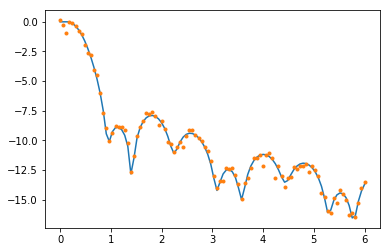

In [10]:
noise = exp.simulateData(noise=3.,modify=False)
plt.plot(angles,np.log(exp.genTheory()))
plt.plot(angles,np.log(noise),'.')

### Reconstructing thickness from noisy curve

[ -4.80807409e-04   1.99942763e+01   3.99743180e+01   1.95818979e+01
  -2.22075312e-04]


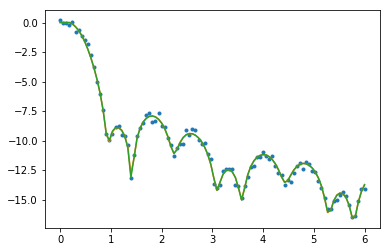

In [11]:
np.random.seed(1334)
struct = B+A+B+subst
angles = np.linspace(0.,6.,100) # Generate an experiment with 100 samples of degrees 0 to 6
exp = struct.doExperiment(angles)
trueR = exp.genTheory()

guess = struct.d.copy()
guess[1] = 15.99 #Perturb thickness a little bit
struct.d = guess

noise = exp.simulateData(noise=2.5, modify=True) #This time we are replacing the theoretical curve with the noisy curve in the experiment

print exp.fixSpacing(guess).d

plt.plot(angles, np.log(noise),'.')
plt.plot(angles, np.log(trueR))
plt.plot(angles,np.log(exp.genTheory()))

Not sure if there's a better way to do noise -- dip too low and it turns out I'm taking the log of 0 or a negative number. 

### Maybe some more complicated structures...

[  0.  40.  20.  40.  20.  40.  20.  40.  20.   0.]
[  3.78918637  40.01249332  19.97864714  40.06043757  19.9375247
  40.01376033  20.00478124  40.03695748  20.24796779   9.0429659 ]


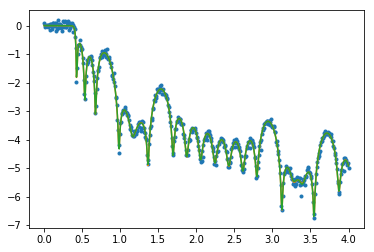

In [12]:
np.random.seed(1334)
struct = A+B+A+B+A+B+A+B+subst
angles = np.linspace(0.,4.,500) # Generate an experiment with 100 samples of degrees 0 to 6
exp = struct.doExperiment(angles)
trueR = exp.genTheory()

print struct.d
guess = struct.d.copy()
guess = guess + np.random.randn(len(guess))*4. #Randomly perturbing thickness
struct.d = guess

noise = exp.simulateData(noise=2., modify=True) #This time we are replacing the theoretical curve with the noisy curve in the experiment

print exp.fixSpacing(guess).d

plt.plot(angles, np.log10(noise),'.')
plt.plot(angles, np.log10(trueR))
plt.plot(angles,np.log10(exp.genTheory()))

Curve generally either converges almost completely or not at all. 

## Neural Network to fit X-Ray Reflectivity

To start, a very very basic toy model where we only vary one of the thicknesses of a layer without any noise. Let's see how the neural network performs. 

In [13]:
import keras #Importing Neural Net stuff
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [14]:
%pylab inline
from sklearn.datasets import make_moons
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

Populating the interactive namespace from numpy and matplotlib


/Users/miro/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['exp']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


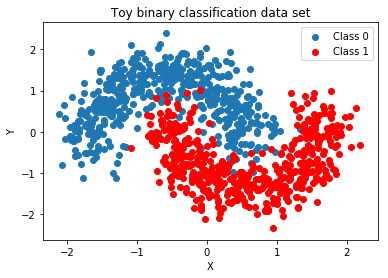

In [15]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [16]:
#Create sequential  multi-layer perceptron
#uncomment if you want to add more layers (in the interest of time we use a shallower model)
model = Sequential()
model.add(Dense(32, input_dim=2,activation='relu')) #X,Y input dimensions. connecting to 32 neurons with relu activation
model.add(Dense(1, activation='sigmoid')) #binary classification so one output

model.compile(optimizer='AdaDelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
tb_callback = keras.callbacks.TensorBoard(log_dir='./Graph/model_1/',
                                          histogram_freq=0, write_graph=True,
                                          write_images=False)

In [18]:
model.fit(X_train, Y_train, batch_size=32, epochs=200,
          verbose=0, validation_data=(X_test, Y_test),callbacks=[tb_callback])
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

('Test loss:', 0.11570022815465927)
('Test accuracy:', 0.95599999952316284)


In [19]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
X, Y = grid
prediction_probs = model.predict_proba(grid_2d, batch_size=32, verbose=0)

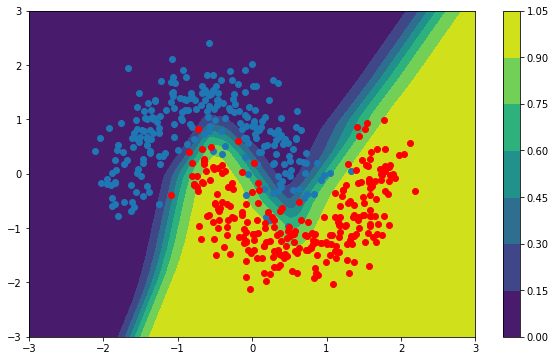

In [20]:
##plot results
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(X, Y, prediction_probs.reshape(100, 100))
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1])
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)